# Initial Exploration - Text Track

For illustration purposes and to establish the pipeline for initial exploration, this analysis uses a dataset containing a sample of 10,000 data points.

In [4]:
from utils.processing import process_parking_ambience_categories
from utils.zipcode import merge_income_data

In [5]:
import pandas as pd

file_path = "yelp_dataset/yelp_sampled_data.csv"
df = pd.read_csv(file_path)

- Data Processing

  **Done:**

    * The **"BusinessParking"** and **"Ambience"** columns contain nested attributes. If present, they store structured data in dictionary-like formats (e.g., for **BusinessParking**:  
    `"{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}"`,  
    for **Ambience**:  
    `"{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}"`).  
    We extracted and processed these nested attributes with one-hot encoding. Also, if a business lacks **BusinessParking** or **Ambience** data, we set all values to zero to handle missing values.

    * The columns **"address," "city," "state," "postal_code," "latitude,"** and **"longitude"** contain geographical location data for restaurants or businesses. We found an augmental dataset on Kaggle with income data that could be joined on ZIP codes.

  **To-Do:**

  * The **"RestaurantsAttire"** column contains inconsistent values, including:  
    `"u'casual'"`, `nan`, `"'casual'"`, `"u'dressy'"`, `"'dressy'"`, `"'formal'"`, `"u'formal'"`.  
    We need to standardize these values and clarify their meanings.

  * The **"categories"** column stores a comma-separated string of labels, such as:  
    `"Restaurants, Gluten-Free, Bars, Food, Nightlife, Sandwiches, Burgers"`.  
    We should split these into individual categorical variables for better usability.

- Text Processing

  Below are some basic text processing methods considered:

  - **Sentiment Analysis**

  - **SBERT Embeddings**

  - **Topic Modeling (LDA)**

  - **TF-IDF Features**

  These methods, while conventional, may introduce excessive noise, sparsity, or irrelevant features. Some approaches (e.g., LDA, TF-IDF) lack deep contextual understanding, while others (e.g., SBERT) may be too complex relative to the dataset size. 
  
  **To-Do:**
  
  * Further Investigation of Existing Methods

    * Evaluate whether they actually help with prediction. We can add one technique at a time to see if it helps with performance. Some other useful techniques include permutation importance or SHAP values for feature selection.
    
    * Implement other preprocessing steps for simple methods (TF-IDF and LDA), including stopword removal, stemming, etc.
    
    * Some minor things to do for specific technique, including hyperparameter tuning for LDA, comparison of sentiment scores against key business indicators to determine their predictive value. Also SBERT embeddings might not be the most optimal embedding, so we can try Word2Vec or GloVe as well. 
  
  * Other NLP Techniques

    * Experiment with domain-specific adaptations of BERT (e.g., DistilBERT, RoBERTa) using a small dataset of labeled business reviews.  

    * Use transformer-based models to extract contextualized word importance instead of relying solely on TF-IDF.  

    * Develop a pipeline combining LDA for topic extraction with embeddings for semantic similarity scoring.  

    * Investigate if zero-shot classifiers like Mistral or OpenAI’s CLIP can generalize well on sentiment and topic classification without requiring extensive labeled data.  

- Modeling

  The current model is used primarily for testing purposes. A key challenge in this project is the severe class imbalance in target variables such as **usefulness** and **price range**, which requires careful handling.

  **To-Do:**
  - select an appropriate model, training strategy, and hyperparameter tuning approach.
  - research and implement techniques to address class imbalance.
  - ...

In [7]:
df = process_parking_ambience_categories(df)
df = merge_income_data(df)

=== Kaggle Income Dataset Insights ===
Initial Kaggle dataset shape: (364998, 111)
Kaggle dataset columns: ['ZIP', 'Geography', 'Geographic Area Name', 'Households', 'Households Margin of Error', 'Households Less Than $10,000', 'Households Less Than $10,000 Margin of Error', 'Households $10,000 to $14,999', 'Households $10,000 to $14,999 Margin of Error', 'Households $15,000 to $24,999', 'Households $15,000 to $24,999 Margin of Error', 'Households $25,000 to $34,999', 'Households $25,000 to $34,999 Margin of Error', 'Households $35,000 to $49,999', 'Households $35,000 to $49,999 Margin of Error', 'Households $50,000 to $74,999', 'Households $50,000 to $74,999 Margin of Error', 'Households $75,000 to $99,999', 'Households $75,000 to $99,999 Margin of Error', 'Households $100,000 to $149,999', 'Households $100,000 to $149,999 Margin of Error', 'Households $150,000 to $199,999', 'Households $150,000 to $199,999 Margin of Error', 'Households $200,000 or More', 'Households $200,000 or More 

/Users/apple/Desktop/Math-148-Project/utils/zipcode.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_combine['ZIP'] = zip_combine['ZIP'].astype(str).str.zfill(5)


In [4]:
df.columns

Index(['user_id', 'business_id', 'stars', 'useful', 'cool', 'text', 'name',
       'address', 'city', 'state', 'latitude', 'longitude', 'business_stars',
       'business_review_count', 'BusinessParking', 'Ambience',
       'RestaurantsAttire', 'RestaurantsPriceRange2', 'user_review_count',
       'user_useful', 'user_funny', 'user_cool', 'average_stars', 'fans',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'garage', 'street',
       'validated', 'lot', 'valet', 'touristy', 'hipster', 'romantic', 'divey',
       'intimate', 'trendy', 'upscale', 'classy', 'casual',
       'Families Median Income (Dollars)', 'Families Mean Income (Dollars)',
       'zip_code'],
      dtype='object')

# Predicting Attributes for Businesses

There are two primary approaches for this dataset:  
1. Predict attributes at the **individual review** level.  
2. Predict attributes at the **business** level.  

If we aim to predict business attributes such as **price range, ambience,** or similar characteristics, the following roadmap outlines the necessary steps.

1. revert to the full dataset (instead of the sample dataset) and apply the following transformations.
2. since the goal is to predict attributes for businesses rather than individual reviews, we should aggregate the dataset at the **business level**.
3. decide how to handle various attributes. Below are suggested approaches:
    - remove `user_id' since user identity is irrelevant for business-level predictions
    - the following attributes should remain **constant** for a business across all its reviews. We can simply copy them from any review associated with that business:  
        - `business_id`
        - `name`
        - `business_stars`
        - `business_review_count`
        - `BusinessParking`
        - `Ambience`
        - `RestaurantsAttire`
        - `RestaurantsPriceRange2`
        - `categories`
    - `stars`, `useful`, `cool`: These are properties of individual reviews. Are they still useful when aggregating at the business level? We need to determine whether to retain, aggregate (e.g., average), or discard them.
    - `user_review_count`, `user_useful`, `user_funny`, `user_cool`, `average_stars`, `fans`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`  
    These attributes describe individual users. Should we **remove** them entirely, or **aggregate** them (e.g., taking the median) as a proxy for a typical reviewer’s profile for each business?
    - `text`: we can combine all review texts for a business into a single large paragraph while maintaining structure to differentiate individual reviews. One possible format:  "{review: ...} {review: ...}..."
4. once the transformations are complete, we should extract a subset of businesses from the full dataset for exploratory analysis.
5. from this point onward, the workflow will align with the framework for predicting at the **individual review level** (outlined later). The main difference will be the **target variable**, but adjusting the framework should be straightforward.


# Predicting Attributes for Individual Reviews

The following code provides an example of how to predict an attribute for each individual review. In this case, we use "useful" votes as the attribute of interest.

For each business, we first calculate the average number of useful votes received across all its reviews. Each individual review is then compared against this average and classified into one of three categories:

- "Average" – if the review's useful votes are close to the business's average.

- "More useful" – if the review has significantly more useful votes than the business's average.

- "Less useful" – if the review has significantly fewer useful votes.

This approach allows us to categorize reviews relative to their business, rather than using an absolute threshold, making the classification more context-aware.

In [2]:
df.columns

Index(['user_id', 'business_id', 'stars', 'useful', 'cool', 'text', 'name',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'business_stars', 'business_review_count', 'BusinessParking',
       'Ambience', 'RestaurantsAttire', 'RestaurantsPriceRange2', 'categories',
       'user_review_count', 'user_useful', 'user_funny', 'user_cool',
       'average_stars', 'fans', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# convert useful votes to useful classifications

df_filtered = df.dropna(subset = ['useful', 'business_id'])

# preprocessing for useful categories
business_avg_useful = df_filtered.groupby('business_id')['useful'].mean().reset_index()
business_avg_useful.rename(columns = {'useful': 'average_business_useful'}, inplace = True)

# merge the average back
df_filtered = df_filtered.merge(business_avg_useful, on = 'business_id', how = 'left')

def classify_useful(row):
    if row['useful'] > row['average_business_useful']:
        return "more useful"
    elif row['useful'] < row['average_business_useful']:
        return "less useful"
    else:
        return "average"

df_filtered['useful_category'] = df_filtered.apply(classify_useful, axis=1)

In [5]:
y = df_filtered['useful_category']
X = df_filtered.drop(columns=['useful', 'average_business_useful', 'useful_category'])

categorical_cols = ['state', 'city', 'categories', 'BusinessParking', 'Ambience', 'RestaurantsAttire']
numerical_cols = ['stars', 'RestaurantsPriceRange2', 'cool', 'business_stars', 'business_review_count',
                  'user_review_count', 'user_useful', 'user_funny', 'user_cool', 'average_stars', 'fans']

In [6]:
# sentiment analysis
df_filtered['sentiment'] = df_filtered['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
numerical_cols.append('sentiment')

In [7]:
# SBERT embeddings

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
text_embeddings_sbert = sbert_model.encode(df_filtered['text'].tolist(), convert_to_numpy = True)
pca_sbert = PCA(n_components = 50, random_state = 42)
text_embeddings_sbert_reduced = pca_sbert.fit_transform(text_embeddings_sbert)
embedding_cols_sbert = [f"text_sbert_pca_{i}" for i in range(50)]
df_embeddings_sbert = pd.DataFrame(text_embeddings_sbert_reduced, columns = embedding_cols_sbert, index = df_filtered.index)
df_filtered = pd.concat([df_filtered, df_embeddings_sbert], axis=1)
numerical_cols.extend(embedding_cols_sbert)

In [8]:
# LDA topic modeling

vectorizer = CountVectorizer(max_features = 1000, stop_words = 'english')
X_text = vectorizer.fit_transform(df_filtered['text'])
lda = LatentDirichletAllocation(n_components = 5, random_state = 42)
lda_topics = lda.fit_transform(X_text)
topic_cols = [f"topic_{i}" for i in range(5)]
df_topics = pd.DataFrame(lda_topics, columns = topic_cols, index = df_filtered.index)
df_filtered = pd.concat([df_filtered, df_topics], axis=1)
numerical_cols.extend(topic_cols)

In [10]:
# TF-IDF
tfidf = TfidfVectorizer(max_features = 500, stop_words = 'english')
X_tfidf = tfidf.fit_transform(df_filtered['text'])
tfidf_cols = [f"tfidf_{word}" for word in tfidf.get_feature_names_out()]
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_cols, index = df_filtered.index)
df_filtered = pd.concat([df_filtered, df_tfidf], axis = 1)
numerical_cols.extend(tfidf_cols)

In [11]:
X = df_filtered.drop(columns = ['text'])

# preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [12]:
# Preprocess data and split into train/test sets
X_encoded = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify = y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight = 
                                    {'average': 1, 'less useful': 20, 'more useful': 20})
classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate model performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

     average       0.83      0.99      0.90      1628
 less useful       0.55      0.10      0.17       211
 more useful       0.63      0.07      0.13       161

    accuracy                           0.82      2000
   macro avg       0.67      0.39      0.40      2000
weighted avg       0.78      0.82      0.76      2000


Accuracy: 0.821


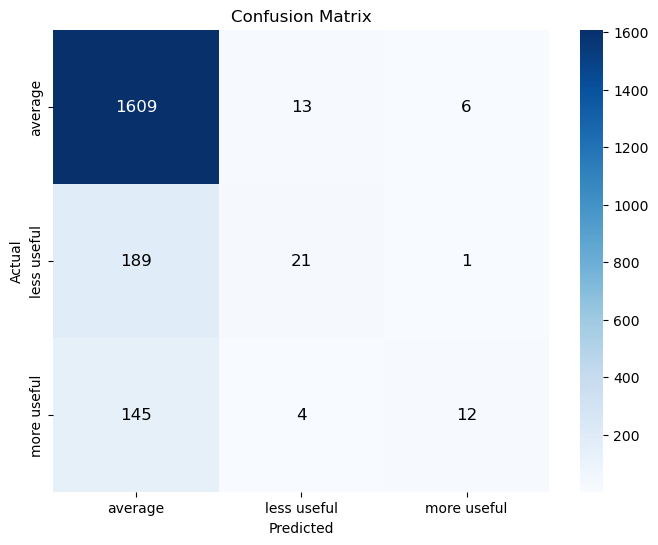

In [13]:
# classification visualization

class_labels = sorted(y.unique())
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot = False, cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
min_val, max_val = conf_matrix.min(), conf_matrix.max()
threshold = (min_val + max_val) / 2

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        text_color = "white" if value > threshold else "black"  # Choose color based on intensity
        ax.text(j + 0.5, i + 0.5, value, ha = 'center', va = 'center', color = text_color, fontsize = 12)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
